In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("Country-data.csv")
df.head(1)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553


In [4]:
df.columns

Index(['country', 'child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp'],
      dtype='str')

In [5]:
df.dtypes


country           str
child_mort    float64
exports       float64
health        float64
imports       float64
income          int64
inflation     float64
life_expec    float64
total_fer     float64
gdpp            int64
dtype: object

In [6]:
df.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

In [8]:
countries = df['country']
X = df.drop('country', axis=1)

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


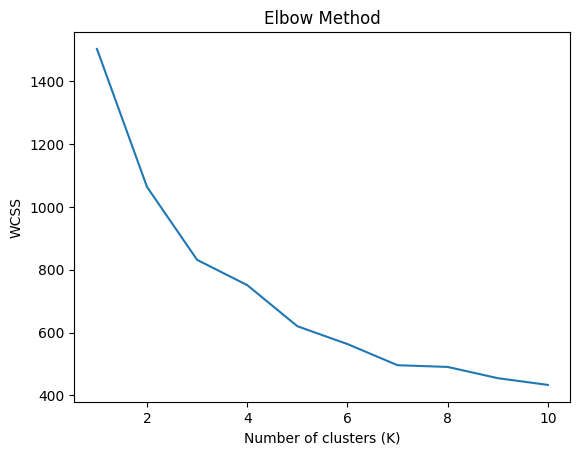

In [11]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []  # within-cluster sum of squares

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# plot
plt.plot(range(1, 11), wcss)
plt.xlabel("Number of clusters (K)")
plt.ylabel("WCSS")
plt.title("Elbow Method")
plt.show()


In [12]:
from sklearn.metrics import silhouette_score

for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"K={k}, Silhouette Score={score:.3f}")


K=2, Silhouette Score=0.266
K=3, Silhouette Score=0.286
K=4, Silhouette Score=0.288
K=5, Silhouette Score=0.301
K=6, Silhouette Score=0.236


In [13]:
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_scaled)


In [14]:
df['cluster'] = clusters
df.head()


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,2
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,0
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,0
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,2
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,0


In [15]:
df['cluster'].value_counts()


cluster
0    87
2    44
1    32
4     3
3     1
Name: count, dtype: int64

In [17]:
cluster_summary = df.groupby('cluster').mean(numeric_only=True)
cluster_summary


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
cluster,,,,,,,,,
0,22.219540,41.083782,6.246667,47.795010,12678.965517,7.727747,72.625287,2.333333,6494.390805
1,5.181250,46.118750,9.088437,40.584375,44021.875000,2.513844,80.081250,1.788437,42118.750000
2,94.313636,28.677500,6.329091,42.872727,3503.250000,9.895568,59.022727,5.047727,1753.909091
3,130.000000,25.300000,5.070000,17.400000,5150.000000,104.000000,60.500000,5.840000,2330.000000
4,4.133333,176.000000,6.793333,156.666667,64033.333333,2.468000,81.433333,1.380000,57566.666667


In [18]:
cluster_summary[['gdpp', 'income', 'life_expec', 'child_mort']]


,gdpp,income,life_expec,child_mort
cluster,,,,
0,6494.390805,12678.965517,72.625287,22.219540
1,42118.750000,44021.875000,80.081250,5.181250
2,1753.909091,3503.250000,59.022727,94.313636
3,2330.000000,5150.000000,60.500000,130.000000
4,57566.666667,64033.333333,81.433333,4.133333


In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


In [20]:
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['cluster'] = df['cluster']
pca_df['country'] = df['country']


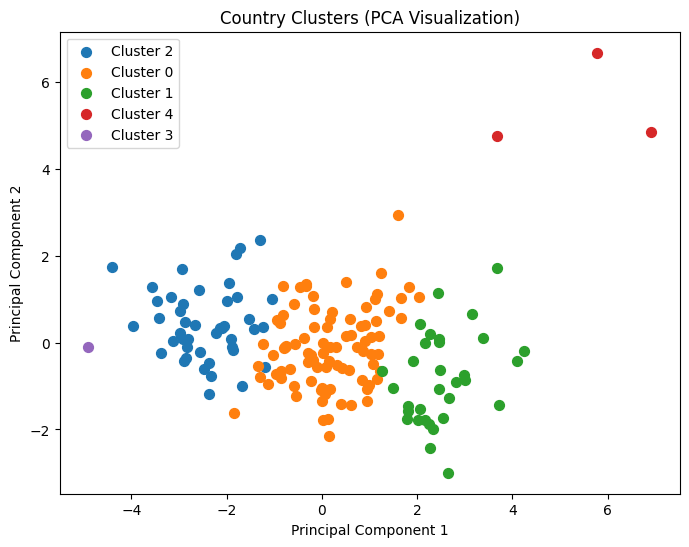

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

for cluster in pca_df['cluster'].unique():
    subset = pca_df[pca_df['cluster'] == cluster]
    plt.scatter(subset['PC1'], subset['PC2'], label=f'Cluster {cluster}', s=50)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Country Clusters (PCA Visualization)')
plt.legend()
plt.show()


In [22]:
outliers = pca_df[pca_df['cluster'].isin([3, 4])]
outliers


,PC1,PC2,cluster,country
91,6.917755,4.849844,4,Luxembourg
98,3.679543,4.765486,4,Malta
113,-4.912066,-0.094499,3,Nigeria
133,5.783376,6.682090,4,Singapore


In [24]:
import pickle

# save model
with open("kmeans_model.pkl", "wb") as f:
    pickle.dump(kmeans, f)

# save scaler
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
